## Forecasting Retail Turnover

In this notebook I attempt to find a forecasting model for the Quarterly Retail Turnover time series data set.  We set out to find which model will perform best.  The models that will be compared are the ARIMA model, Exponential Smoothing Model, and a Regression-based Model.  In order to find which model is best among the three, we can set aside a portion of the last observations as a holdout sample and fit our model to the rest of the observations.  Whichever model best explains the autocorrelation in the errors, passes the white noise test, and gives the most accurate predictions for our holdout sample will be our best model.  We end this project by then describing the benefits and limitations of using the different models.


### Data 

The data used in this project comes from [here.]( https://datamarket.com/data/set/22n7/quarterly-retail-turnover-m-current-jun-1982-dec-1991#!ds=22n7&display=line
)


In [145]:
title 'Retail Turnover from 1982 to 1992';
ods noproctitle;
options validvarname=v7;
%let path = /folders/myfolders/sasuser.v94/quarterly-retail-turnover.csv;

proc import datafile="&path" dbms=csv out=retail replace;
run;

proc print data=retail;
run;

Obs,Quarter,Quarterly_Retail_Turnover
1,1982Q3,13423.2
2,1982Q4,13128.8
3,1983Q1,15398.8
4,1983Q2,12964.2
5,1983Q3,13133.5
6,1983Q4,13271.7
7,1984Q1,15596.3
8,1984Q2,13018
9,1984Q3,13409.3
10,1984Q4,13304.2


The dataset has 39 observations, so we can hold back the last 12 observations as our holdout sample when performing model estimation.  Just a quick note, this RetailTurnover.ipynb is a symoblic link pointing to a file in a shared folder being used with VirtualBox (I'm using SAS University Edition).  That's why the relative path here seems off.  I did this so I could keep all of my data analysis notebooks in a single repository.


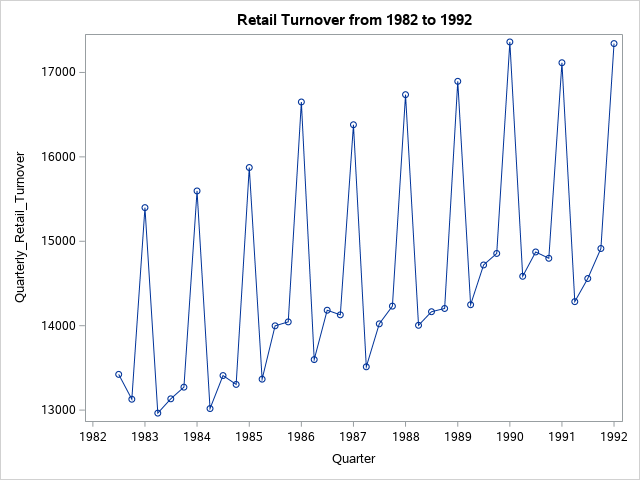

In [146]:
proc sgplot data=retail;
    series x=quarter y=quarterly_retail_turnover /markers;
run;

Here we just plot the data to see if there’s anything that stands out.  One of the first things we notice is that the turnover seems to fluctuate around an average that increases in a linear fashion over time.  This suggests that we should include a linear trend component when using a time series regression model.  We can also see increasing seasonal variation which means we should apply a transformation to our response variable and incorporate 3 seasonal dummy variables for the 4 quarters.


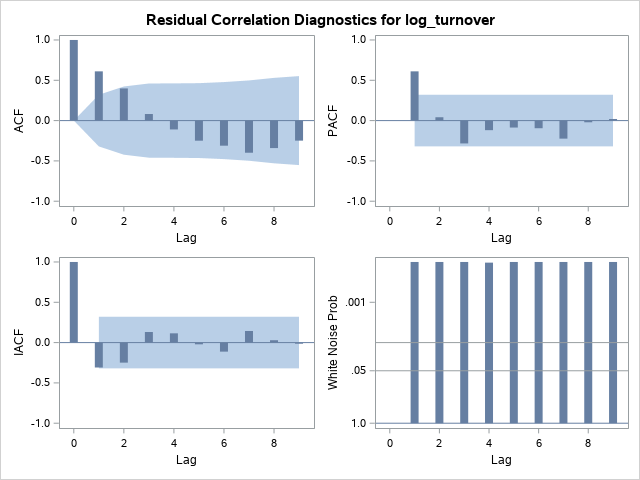
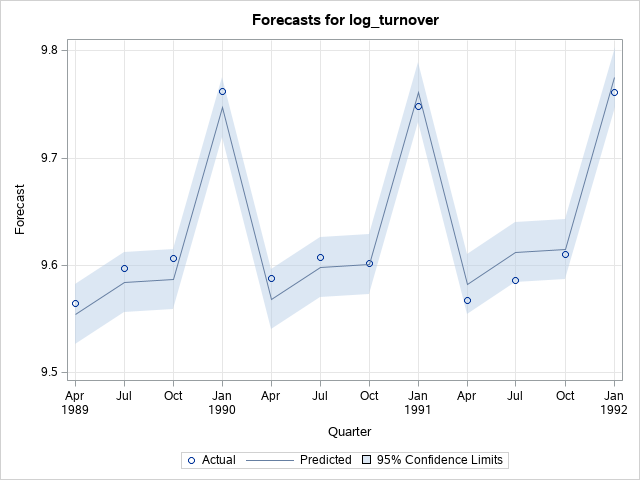

In [147]:
data retail;
    set retail;

    if qtr(Quarter)=1 then
        do;
            Q1=1;
            Q2=0;
            Q3=0;
        end;
    else if qtr(Quarter)=2 then
        do;
            Q1=0;
            Q2=1;
            Q3=0;
        end;
    else if qtr(Quarter)=3 then
        do;
            Q1=0;
            Q2=0;
            Q3=1;
        end;
    else
        do;
            Q1=0;
            Q2=0;
            Q3=0;
        end;
    log_turnover=log(quarterly_retail_turnover);
run;

title2 "Regression Model (Attempt 1)";

proc arima data=retail plots (only)=(residual(corr) forecast(forecastonly));
    identify var=log_turnover crosscorr=(Quarter Q1 Q2 Q3);
    estimate input=(Quarter Q1 Q2 Q3);
    forecast lead=12 back=12 id=Quarter interval=qtr;
run;

Looking at our output shows that our intercept, linear trend, Q1, and Q2 variables are all signficant.  We can see this by conducting the following hypothesis testing:


  * $H_0: b_i = 0$
  * $H_a:$ $b_i \neq$ 0
 

Our null hypothesis states that the given independant variable doesn't contribute any explanatory power to our model whereas the alternative hypothesis states that it does.  The p-value here is the likelihood that we would observe the given $T$-statistic assuming that our null hypothesis is true (Area under $T^{\mathrm{34}}_{0.025}$ to the right of the $T$-statistic).  Our significance level or $\alpha$ is set at 0.05.  Our $\alpha$ is just the probability of getting a Type 1 error/False positive.  Since the p-value is lower then our alpha, we can reject our null hypothesis in favor of the alternative.  This means that this coefficient has some explanatory power.  The only coefficicent that isn't significant is Q3 but that needs to stay in our model if we choose to use seasonal components.


When looking at the autocorrelation plots we can see a significant spike at lag 1 which suggests significant autocorrelation with lag 1.  Looking at the White Noise probabilty plot, we see that all of the lags are signigicant so we reject the null hypothesis:

  * $H_0:$ Prediction errors represent white noise.


Since the white noise test failed and there is autocorrelation present we can try a multiple linear regression model with a trend variable, seasonal dummy variables, and autoregressive errors.  The ARIMA procedure in SAS allows us to obtain point estimates for our intercept and independant variables as well as model the error terms with a first-order autogregressive process.


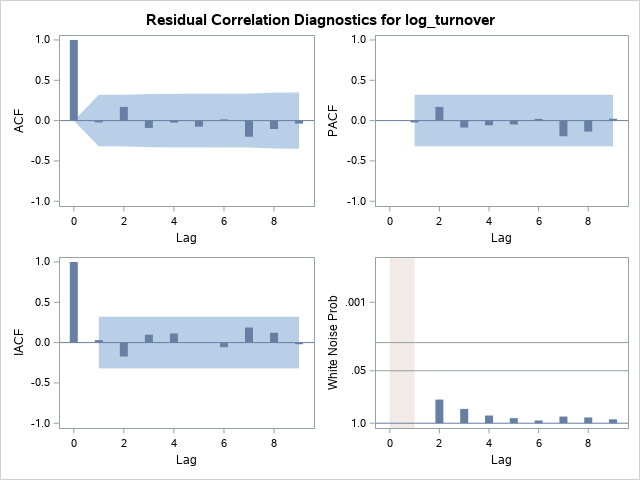
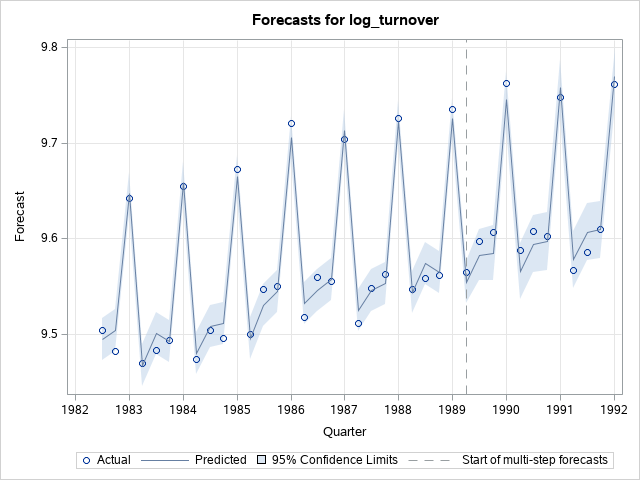

In [148]:
title2 "Regression Model (Attempt 2)";

proc arima data=retail plots (only)=(residual(corr) forecast(forecast));
    identify var=log_turnover crosscorr=(Quarter Q1 Q2 Q3);
    estimate p=(1) input=(Quarter Q1 Q2 Q3);
    forecast back=12 lead=12 id=Quarter interval=qtr out=forecast1;
run;

After we add AR(1) to this model we see no more significant spikes in the autocorrelation plots for any of the lags.  We can also see that this model passes the white noise test.  Looking at the forecasts of the holdout samples we can see that the model follows the data fairly well.  The model can be written as:

$\widehat{log(Turnover_{T})} = 9.21278 + 0.00003(Quarter) + 0.15742(Q1) - 0.02522(Q2) + 0.00052(Q3) + 0.68195(log(Turnover_{T-1}))$

Where T is the number of days from January 1, 1960 to the begining of the Quarter.

We can now build an exponential smoothing model and see how it compares with this regression-based one.


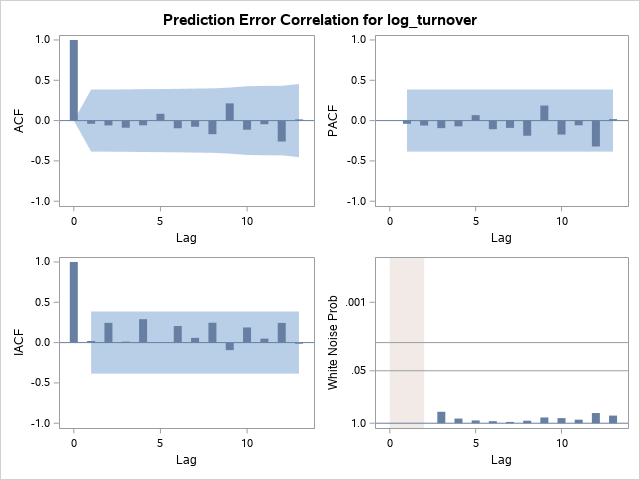
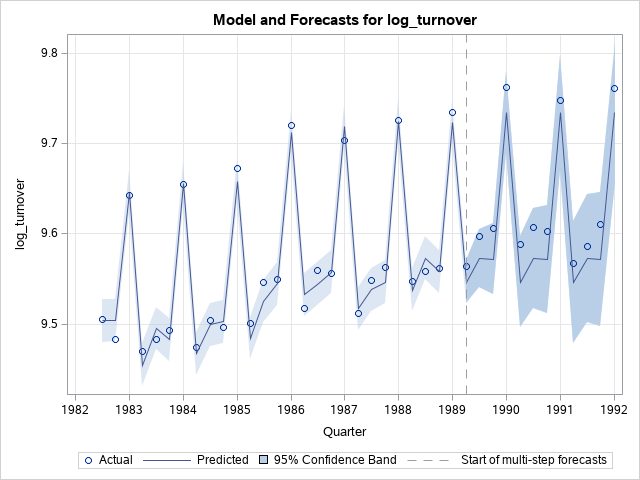

In [149]:
title2 "ESM Model";

proc esm data=retail seasonality=4 back=12 lead=12 outfor=forecast2
    plot=(corr modelforecasts) print=(estimates);
    id Quarter interval=qtr;
    forecast log_turnover / model=seasonal;
run;

In an Exponential Smoothing Model we use a smoothing constant ($\alpha$) that allows us to give more weigh to the most recent observations.  The weight declines exponentially as time passes so older observations will successively be given lower weights.  $\alpha$ is a number between 0 and 1.  The larger $\alpha$ is the more our predicted value will depend on the more current values and vice versa.  The alpha is typically selected to minimize the SSE of the errors.  Gamma ($\gamma$) is another smoothing constant used in the forecast and is also between 0 and 1.  $\alpha$ is the smoothing constant for the level of our series and $\gamma$ is the smoothing constant of the seasonal factors.  In the output we see that SAS has estimated  $\alpha$ = 0.94111 and $\gamma$ = 0.26430.  The general equation for this model can be found [here](http://support.sas.com/documentation/cdl/en/etsug/67525/HTML/default/viewer.htm#etsug_tffordet_sect021.htm).

In the output we don't see any significant lags in the autocorrelation plots.  This model also passes the white noise test so we can say that the autocorrelation for the plots have been dealt with.  In the forecast plot we can see the prediction interval for the predicted value gradually widening as time goes on which is to be expected.  The model becomes less accurate as time passes.  

Next we look at an ARIMA model.


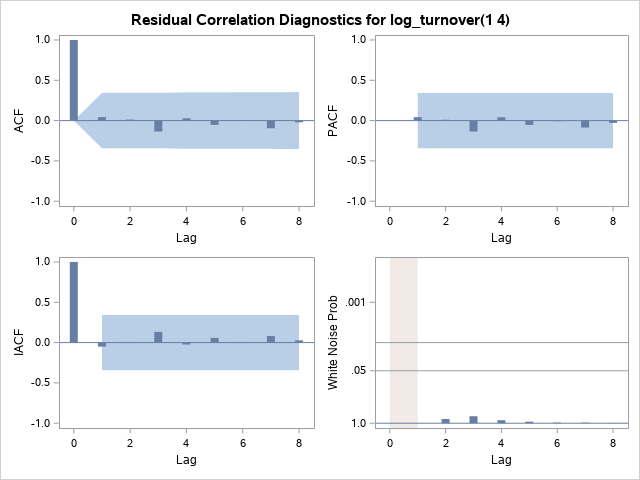
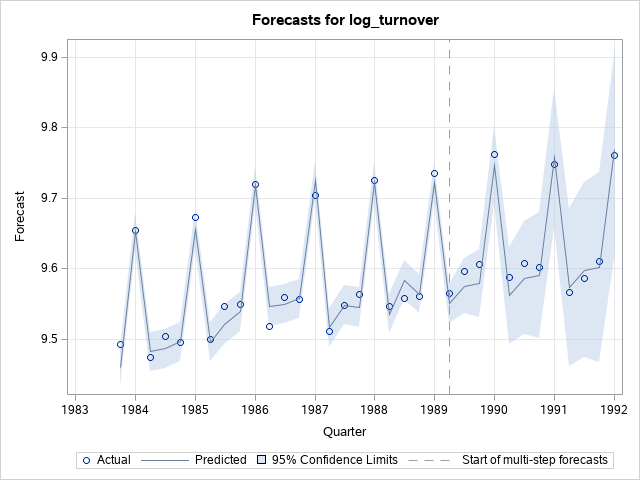

In [150]:
title2 "ARIMA Model";

proc arima data=retail plots (only)=(residual(corr) forecast(forecast));
    identify var=log_turnover(1, 4);
    estimate q=(4) noint;
    forecast back=12 lead=12 id=Quarter interval=qtr out=forecast3;
run;

In this Autoregressive integrated Moving Average (ARIMA) model we use differencing instead of trend and seasonal components/dummy variables.  We use differencing to transform our data from a nonstationary time series (non constant mean or variance) to a stationary series.  In this time series we take a first difference and a fourth difference to account for the linear trend and seasonal pattern.  After some experimenting, I found this ARIMA model to perform the best.  In addition to the differencing, we also included a fourth-order moving average component in the model.  


In the autocorrelation function plots we see that there are no significant lags.  We can also see that this model passes the white noise test.  Just like the ESM model, the prediction intervals of the forecasted value continues to widen as move towards our holdout data because this model also becomes less precise as time passes.

Next we move to compare the three models and see which performed best.


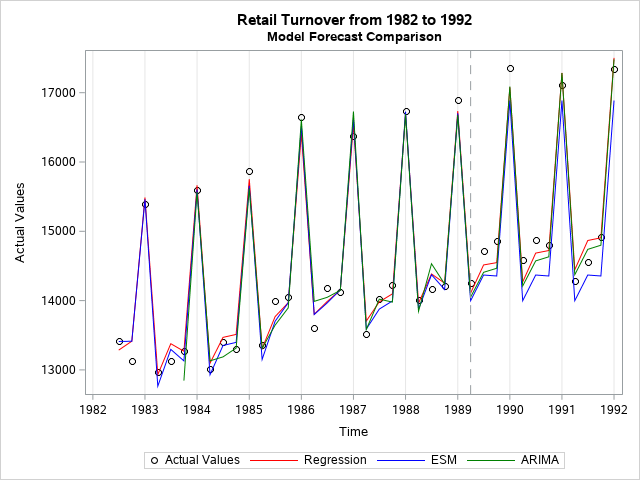

In [151]:
title2 "Model Forecast Comparison";

data forecast;
    set forecast1;
    Time=Quarter;
    Regression=exp(forecast);
    Regression_Error = exp(residual);
    format Time yyq6.;
    
    set forecast2;
    Actual=exp(actual);
    ESM=exp(predict);
    ESM_Error = exp(error);
    
    set forecast3;
    ARIMA=exp(forecast);
    ARIMA_Error=exp(residual);

    keep Time Actual Regression ESM ARIMA Regression_Error ESM_Error ARIMA_Error;
run;


proc sgplot data=forecast;
    scatter x=Time y=Actual/ markerattrs=(color=Black);
    series x=Time y=Regression/ lineattrs=(color=Red);
    series x=Time y=ESM/ lineattrs=(color=Blue);
    series x=Time y=ARIMA/ lineattrs=(color=Green);
    refline "01Apr1989"d /axis=x lineattrs=(pattern=dash);
    xaxis grid;
run;

By eyeing the plot it isn't immediately obvious which model performed best.  The ESM model seems to have the worst performance of the three.  It's almost always the furthest point from the actual values in our holdout sample.  The regression and ARIMA model seem to perform fairly similar but I would say that the ARIMA model performs slightly better.  To me it seems to follow both the holdout sample and the fitted data best.  


### Discussion
---


In [152]:
ods proctitle;
title;
title2;